In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight
import tensorflow.keras.layers as layers
from data_generator import NpyDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from tqdm import tqdm
from collections import Counter
import numpy as np
from tensorflow.keras.optimizers import RMSprop, SGD, Adam,Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.layers import *
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
# import einops

2023-04-14 12:07:27.353813: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
train_path = "/media/kashraf/Elements/Dissertation/data/preprocessed/visual/single_trial/3D_wt_data/stack/train"
test_path = "/media/kashraf/Elements/Dissertation/data/preprocessed/visual/single_trial/3D_wt_data/stack/test"
train_gen = NpyDataGenerator(train_path,batch_size=4)
validation_gen = NpyDataGenerator(test_path,batch_size=1,shuffle=False)
print("Training samples: ",train_gen.num_samples)
print("Test samples: ",validation_gen.num_samples)

Training samples:  2164
Test samples:  934


In [7]:


def residual_block(input_tensor, filters):
    x = Conv3D(filters, kernel_size=(3,3,3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(filters, kernel_size=(3,3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

input_shape = (112, 112,176, 1)
inputs = tf.keras.layers.Input(shape=input_shape)

x = Conv3D(16, kernel_size=(3,3,3), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = residual_block(x, 16)
x = residual_block(x, 16)
x = Conv3D(32, kernel_size=(3,3,3), strides=(2,2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = residual_block(x, 32)
x = residual_block(x, 32)
x = Conv3D(64, kernel_size=(3,3,3), strides=(2,2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = residual_block(x, 64)
x = residual_block(x, 64)
x = tf.keras.layers.GlobalAveragePooling3D()(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [8]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 112, 112, 17 0                                            
__________________________________________________________________________________________________
conv3d_30 (Conv3D)              (None, 112, 112, 176 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 112, 112, 176 64          conv3d_30[0][0]                  
__________________________________________________________________________________________________
activation_30 (Activation)      (None, 112, 112, 176 0           batch_normalization_30[0][0]     
____________________________________________________________________________________________

### Train the model

In [ ]:
             
checkpoint = ModelCheckpoint("/media/kashraf/Elements/Dissertation/modelling/General/weights/3D_CNN_residual.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.01,
                              patience = 5,
                              verbose = 1,
                              min_delta = 0.000001)

# we put our call backs into a callback list
callbacks = [ checkpoint,reduce_lr,earlystop]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(),
              metrics = ['accuracy'])


epochs = 100

history= model.fit(   
    train_gen,
    epochs = epochs,
    callbacks =callbacks,
    validation_data = validation_gen)

2023-04-14 12:11:29.513835: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-14 12:11:29.531648: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz


Epoch 1/100


2023-04-14 12:11:31.513221: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-14 12:11:32.911231: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


541/541 [==============================] - 1121s 2s/step - loss: 1.6521 - accuracy: 0.3795 - val_loss: 17.9261 - val_accuracy: 0.2313

Epoch 00001: val_loss improved from inf to 17.92613, saving model to /media/kashraf/Elements/Dissertation/modelling/General/weights/3D_CNN_residual.h5
Epoch 2/100
541/541 [==============================] - 1417s 3s/step - loss: 0.7818 - accuracy: 0.5681 - val_loss: 4.9890 - val_accuracy: 0.2452

Epoch 00002: val_loss improved from 17.92613 to 4.98897, saving model to /media/kashraf/Elements/Dissertation/modelling/General/weights/3D_CNN_residual.h5
Epoch 3/100
541/541 [==============================] - 1397s 3s/step - loss: 0.5154 - accuracy: 0.6486 - val_loss: 1.6197 - val_accuracy: 0.5439

Epoch 00003: val_loss improved from 4.98897 to 1.61973, saving model to /media/kashraf/Elements/Dissertation/modelling/General/weights/3D_CNN_residual.h5
Epoch 4/100
541/541 [==============================] - 1430s 3s/step - loss: 0.4266 - accuracy: 0.6844 - val_loss

In [6]:
results_path = "/media/kashraf/Elements/Dissertation/modelling/General/results/AE_denoised/figures/beta/2+1D CNN"


### Curves

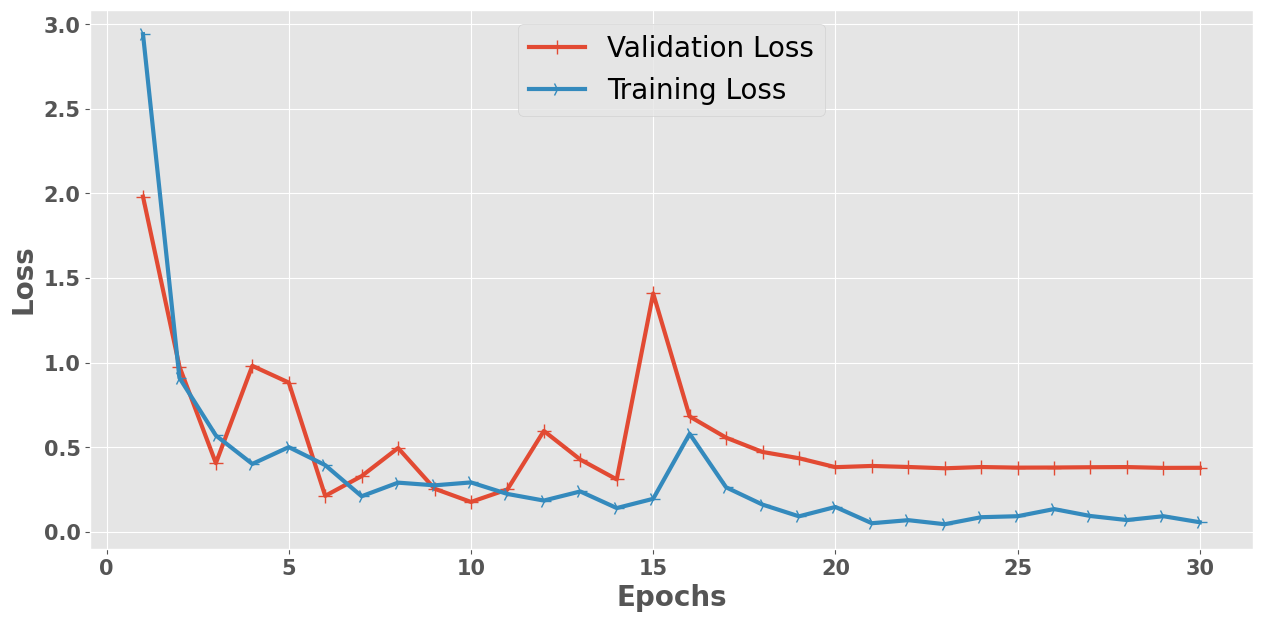

In [7]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(15,7))
plt.xticks(fontsize=13,weight="bold")
plt.yticks(fontsize=13,weight="bold")
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=3.0,marker = '+', markersize=10.0)
plt.setp(line2, linewidth=3.0,marker = '4', markersize=10.0)
plt.xlabel('Epochs',fontsize=20,weight="bold") 
plt.ylabel('Loss',fontsize=20,weight="bold")
plt.grid(True)
plt.xticks(fontsize=15,weight="bold")
plt.yticks(fontsize=15,weight="bold")
plt.legend(fontsize=20,loc = "upper center")
plt.savefig(os.path.join(results_path,'Loss_stack_3D_CNN_rmsprop.png'),bbox_inches ="tight",pad_inches =0)
plt.show()


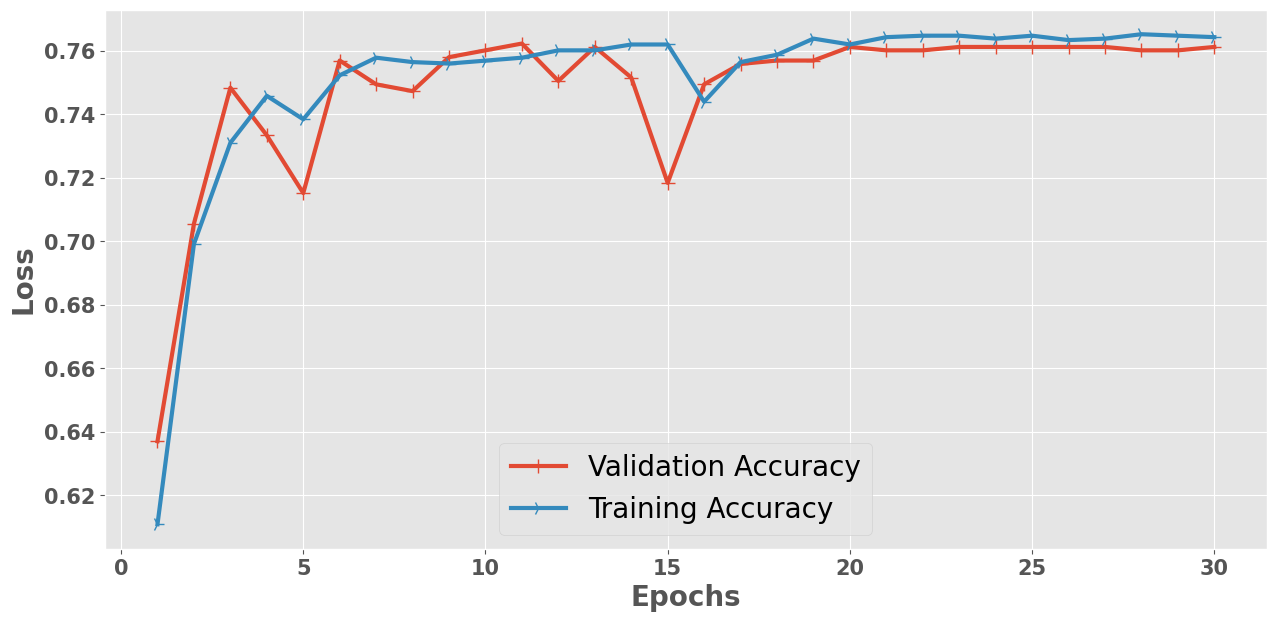

In [8]:

plt.style.use("ggplot")
plt.figure(figsize=(15,7))
plt.xticks(fontsize=13,weight="bold")
plt.yticks(fontsize=13,weight="bold")
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation Accuracy')
line2 = plt.plot(epochs, acc_values , label='Training Accuracy')
plt.setp(line1, linewidth=3.0,marker = '+', markersize=10.0)
plt.setp(line2, linewidth=3.0,marker = '4', markersize=10.0)
plt.xlabel('Epochs',fontsize=20,weight="bold") 
plt.ylabel('Loss',fontsize=20,weight="bold")
plt.grid(True)
plt.xticks(fontsize=15,weight="bold")
plt.yticks(fontsize=15,weight="bold")
plt.legend(fontsize=20,loc= "lower center")
plt.savefig(os.path.join(results_path,'Accuracy_stack_3D_CNN_rmsprop.png'),bbox_inches ="tight",pad_inches =0)
plt.show()


In [10]:
path = "/media/kashraf/Elements/Dissertation/data/preprocessed/visual/single_trial/3D_wt_data/stack/test"
cl2_labels = [0]*len(os.listdir(os.path.join(path,"cl2")))
cl4_labels = [1]*len(os.listdir(os.path.join(path,"cl4")))
cl6_labels = [2]*len(os.listdir(os.path.join(path,"cl6")))
cl8_labels = [3]*len(os.listdir(os.path.join(path,"cl8")))

labels = np.concatenate([cl2_labels,cl4_labels,cl6_labels,cl8_labels])
labels.shape

(934,)

In [15]:
import seaborn as sr
import pandas as pd
# model= load_model("/media/kashraf/Elements/Dissertation/modelling/General/weights/3D_CNN.h5")
validation_gen = NpyDataGenerator(test_path,batch_size=1,shuffle=False)
y_test = labels
y_pred= np.argmax(model.predict(validation_gen), axis=1)


plt.style.use("ggplot")
class_names=["CL_1","CL_2","CL_3","CL_4"]


/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kashraf/miniconda3/envs/tensorflow/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m


 Classification report: 
               precision    recall  f1-score   support

        CL_1       0.00      0.00      0.00       216
        CL_2       0.89      1.00      0.94       216
        CL_3       0.87      0.97      0.92       216
        CL_4       0.63      1.00      0.78       286

    accuracy                           0.76       934
   macro avg       0.60      0.74      0.66       934
weighted avg       0.60      0.76      0.67       934



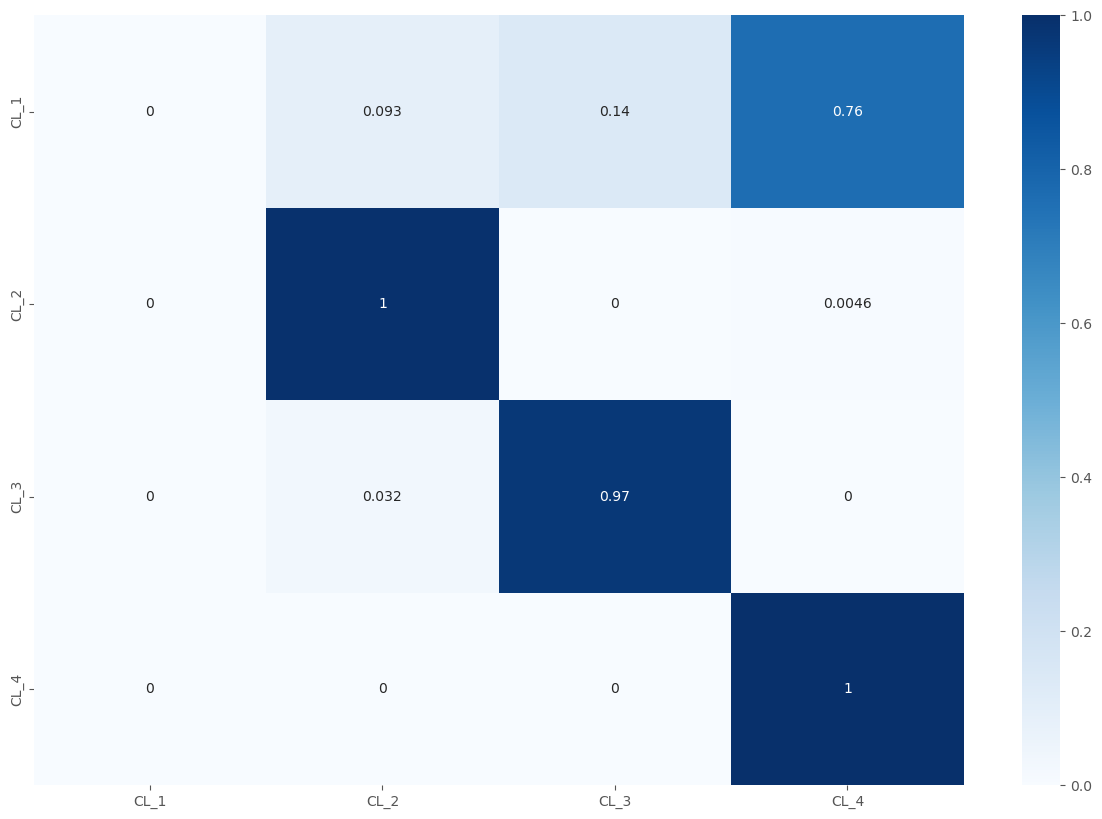

In [13]:
report=classification_report(y_test,y_pred,target_names=class_names)
np.save(os.path.join(results_path,'Report_beta_3D_CNN.npy'),report)

conf=confusion_matrix(y_test,y_pred,normalize="true")
conf_df=pd.DataFrame(conf, index=class_names, columns=class_names)
# print("\nFace  accuracy =",accuracy)
print("\n Classification report: \n",report)
fig=plt.figure(figsize=(15,10))
sr.heatmap(conf_df,annot=True,cmap="Blues")
# plt.title("Confusion matrix")
plt.savefig(os.path.join(results_path,'Conf_Mat_stack_3D_CNN.png'))
plt.show()

In [14]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-04-14 11:52:57.002174: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-14 11:52:57.152598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 11:52:57.170913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-04-14 11:52:57.177195: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-14 11:52:57.182048: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-14 11:52:57.182163: I tensorflow/stream_executor/plat

True

ead from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 11:52:57.183969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1862] Adding visible gpu devices: 0
2023-04-14 11:52:57.218348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-04-14 11:52:57.218421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2023-04-14 11:52:57.218445: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2023-04-14 11:52:57.232617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 11:52:57.233395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
